- **Author**: tootouch

- **Paper**: [Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps](https://arxiv.org/pdf/1312.6034v2.pdf)

![image](https://user-images.githubusercontent.com/37654013/134555177-ff3be5a1-5173-48fe-90bf-3296467f7dee.png)

In [19]:
import numpy as np
import torch

import timm
import torchvision.transforms as transforms
from torchvision import models
from torch.autograd import Variable

from PIL import Image, ImageFilter
import copy

import matplotlib.pyplot as plt
import pandas as pd
import json

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
class_idx = json.load(open('../imagenet_class_index.json','r'))

In [22]:
class_df = pd.DataFrame(class_idx).T
class_df.columns = ['id','name']

In [54]:
net = timm.create_model('vit_base_patch16_224', pretrained=True)
net.eval()
net.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn

In [55]:
sum([m.numel() for m in net.parameters()])

86567656

In [56]:
def preprocessed_image(img, mean, std, blur_rad=None):
    #ensure or transform incoming image to PIL image
    img = Image.fromarray(img)
            
    #add gaussin blur to image
    if blur_rad:
        img = img.filter(ImageFilter.GaussianBlur(blur_rad))
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    return transform(img).unsqueeze(0).requires_grad_(True)

def visualize_filter(model, class_index, device, blur_rad=1, blur_freq=4, verbose=False, **kwargs):
    iterations = kwargs.get('iteration',30)
    learning_rate = kwargs.get('learning_rate',0.1)
    eval_every = kwargs.get('eval_every',10)
    
    # initialize image
    img = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
    
    for iteration in range(iterations):
        if iteration % blur_freq == 0:
            pre_img = preprocessed_image(img,
                                         mean=model.default_cfg['mean'],
                                         std=model.default_cfg['std'],
                                         blur_rad=blur_rad)
        else:
            pre_img = preprocessed_image(img,
                                         mean=model.default_cfg['mean'],
                                         std=model.default_cfg['std'])
        
        # optimizer
        optimizer = torch.optim.AdamW([pre_img], lr=learning_rate, weight_decay=0.0001)
    
        
        output = model(pre_img.to(device))
        
        # compute gradients
        optimizer.zero_grad()
        class_loss = -output[0,class_index]
        class_loss.backward()
        
        # gradients clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                
        optimizer.step()
        
        if iteration % eval_every == 0 and verbose:
            print('loss: ',class_loss.item())
        
        img = deprocess_image(pre_img,
                              mean=model.default_cfg['mean'],
                              std=model.default_cfg['std'])
    
    return img

def deprocess_image(img, mean, std):
    img = copy.copy(img[0].detach().cpu().numpy())
    # Normalize array: center on 0., ensure variance is 0.15
    mean = np.expand_dims(mean, axis=[1,2])
    std = np.expand_dims(std, axis=[1,2])
    img = (img*std) + mean

    img = np.clip(img, 0, 1)
    
    img = np.round(img*255).astype(np.uint8)
    return np.transpose(img, axes=[1,2,0])

In [59]:
cls_list = ['cup','flamingo','dumbbell','dalmatian','bell_pepper','lemon','husky',
            'washing_machine','computer_keyboard','kit_fox','goose','ostrich']
target_idx = class_df[class_df['name'].isin(cls_list)]
target_idx

,id,name
9,n01518878,ostrich
99,n01855672,goose
130,n02007558,flamingo
251,n02110341,dalmatian
278,n02119789,kit_fox
508,n03085013,computer_keyboard
543,n03255030,dumbbell
945,n07720875,bell_pepper
951,n07749582,lemon
968,n07930864,cup


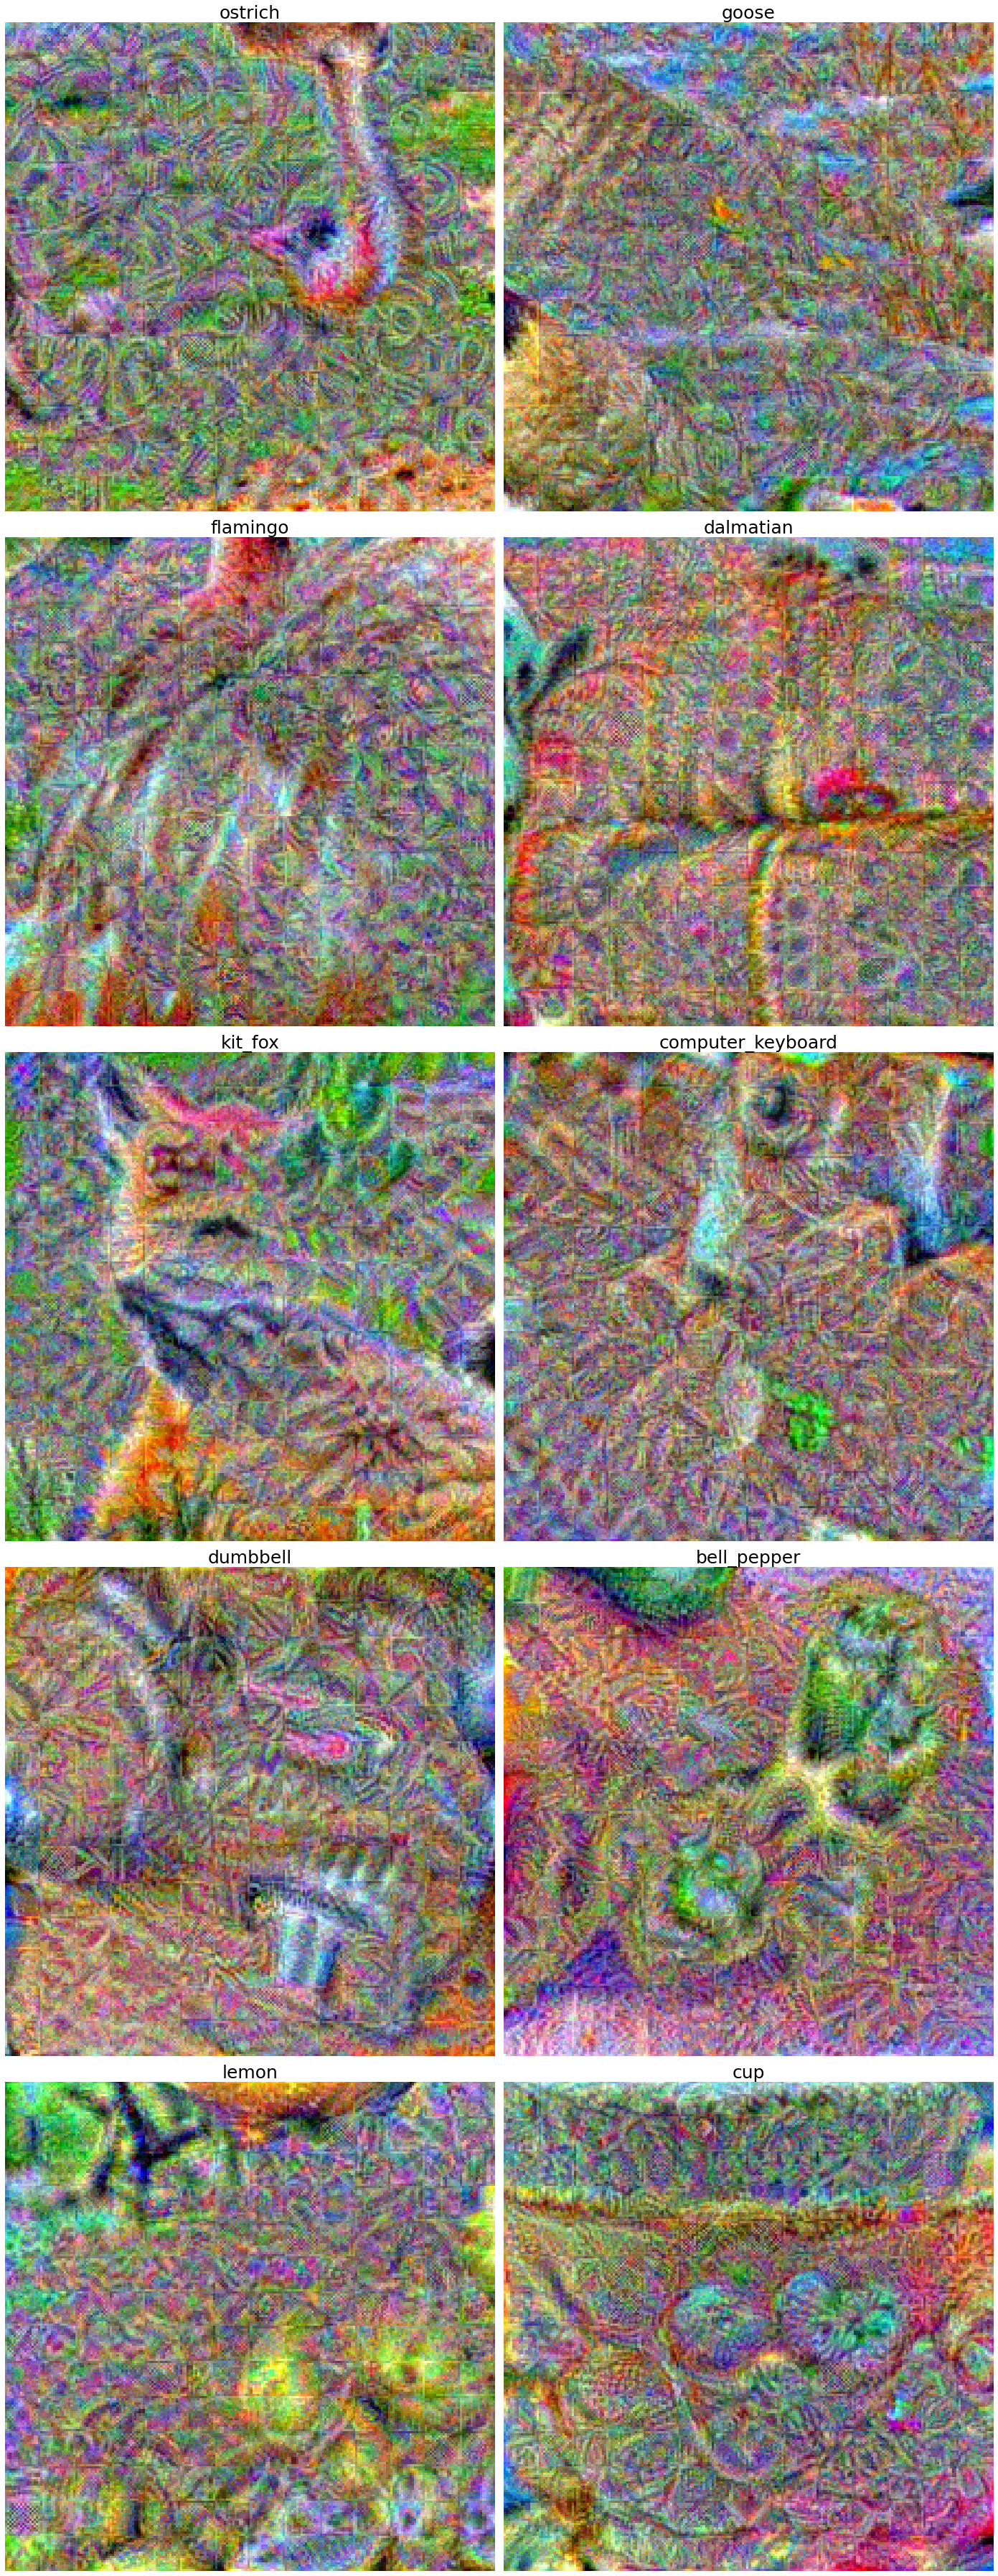

In [65]:
f, ax = plt.subplots(5,2, figsize=(20,50))
for i, idx in enumerate(target_idx.index):
    image = visualize_filter(net, int(idx), device=device, eval_every=50, learning_rate=0.1, iteration=300)

    ax[i//2, i%2].imshow(image)
    ax[i//2, i%2].set_title(target_idx.loc[idx, 'name'], size=25)
    ax[i//2, i%2].axis('off')

plt.tight_layout()
plt.savefig('vit_class_vis.jpg',dpi=50)
plt.show()